# Challenges in Representation Learning: Facial Expression Recognition Challenge
### _Learn facial expressions from an image_
#### https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/overview

# 目次

1. **[プロジェクト概要](#1)**
2. **[データクリーニング](#2)**
3. **[探索的データ解析](#3)**
4. **[機械学習](#4)**
5. **[結果、まとめ](#5)**

# 1, プロジェクト概要 <a id="1"></a>

### 1.1 プロジェクトの説明
- このプロジェクトは48x48ピクセルの顔写真からその顔写真がどんな感情の顔かを識別するプロジェクトです。
- 写真は黒白写真です.
- 感情は'Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral'の7種類です。

# 2, データクリーニング <a id="2"></a>

### 2.1 データを読み込む

In [1]:
#1
#kaggle_36
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
#from keras.optimizers import RMSprop,Adam
from tensorflow.keras.optimizers import RMSprop
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
#2
# train_df_original = pd.read_csv('kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv')
# test_df_original = pd.read_csv('kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv')
# example_submission_df_original = pd.read_csv('kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv')
icml_face_data_df_original = pd.read_csv('kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')

In [3]:
#3
icml_face_data_df = icml_face_data_df_original.copy()

In [4]:
#4
icml_face_data_df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
icml_face_data_df[' Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name:  Usage, dtype: int64

In [6]:
# train_df = icml_face_data_df[icml_face_data_df[' Usage']=='Training']
# val_df = icml_face_data_df[icml_face_data_df[' Usage']=='PrivateTest']
# test_df = icml_face_data_df[icml_face_data_df[' Usage']=='PublicTest']

### 2.1 データを適切な値に変換する
- train_dfの'pixels'の値が '70 80 82 ...'のようになっているので[70,80,82 ...]のようにリストにしてその後そのリストを48x48x1にサイズを変換する。

In [7]:
#5
def pixels_to_array(pixels):
    array = np.array(pixels.split(),'float64')
    return array

def image_reshape(data):
    image = np.reshape(data.to_list(),(data.shape[0],48,48,1))
    return image

In [8]:
icml_face_data_df[' pixels'] = icml_face_data_df[' pixels'].apply(pixels_to_array)

In [9]:
train_df = icml_face_data_df[icml_face_data_df[' Usage']=='Training']
val_df = icml_face_data_df[icml_face_data_df[' Usage']=='PrivateTest']
test_df = icml_face_data_df[icml_face_data_df[' Usage']=='PublicTest']

In [10]:
X_train = image_reshape(train_df[' pixels'])
y_train = train_df['emotion']

In [11]:
X_val = image_reshape(val_df[' pixels'])
y_val = val_df['emotion']

In [12]:
X_test = image_reshape(test_df[' pixels'])
y_test = test_df['emotion']

# 3, 探索的データ解析 <a id="3"></a>

### 3.1 写真の各感情の割合を確認する。

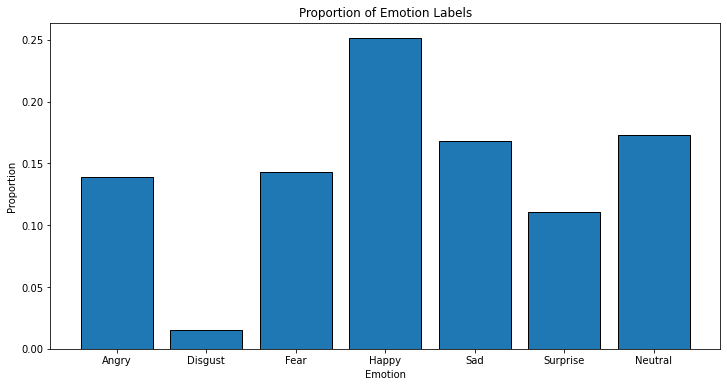

In [13]:
#8
#感情の割合のグラフを作成
emotion_prop = (train_df.emotion.value_counts() / len(train_df)).to_frame().sort_index(ascending=True)
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

plt.figure(figsize=[12,6])

plt.bar(x=emotions, height=emotion_prop['emotion'], edgecolor='black')
    
plt.xlabel('Emotion')
plt.ylabel('Proportion')
plt.title('Proportion of Emotion Labels')
plt.show()

- Happyが25%と一番多く、Disgustが2%ぐらいと極端に少ない
- モデルに'class_weight'を加えてデータ数の多いラベルの重みを軽くし、データ数の少ないラベルの重みを重くする。

In [14]:
#9
#class_weightを作成
class_weight = dict(zip(range(0, 7), (((y_train.value_counts()).sort_index())/len(train_df['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

In [15]:
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [16]:
#class_weight = generate_class_weights(y_train.values)

In [17]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

### 3.2 写真の各感情ごとに確認する

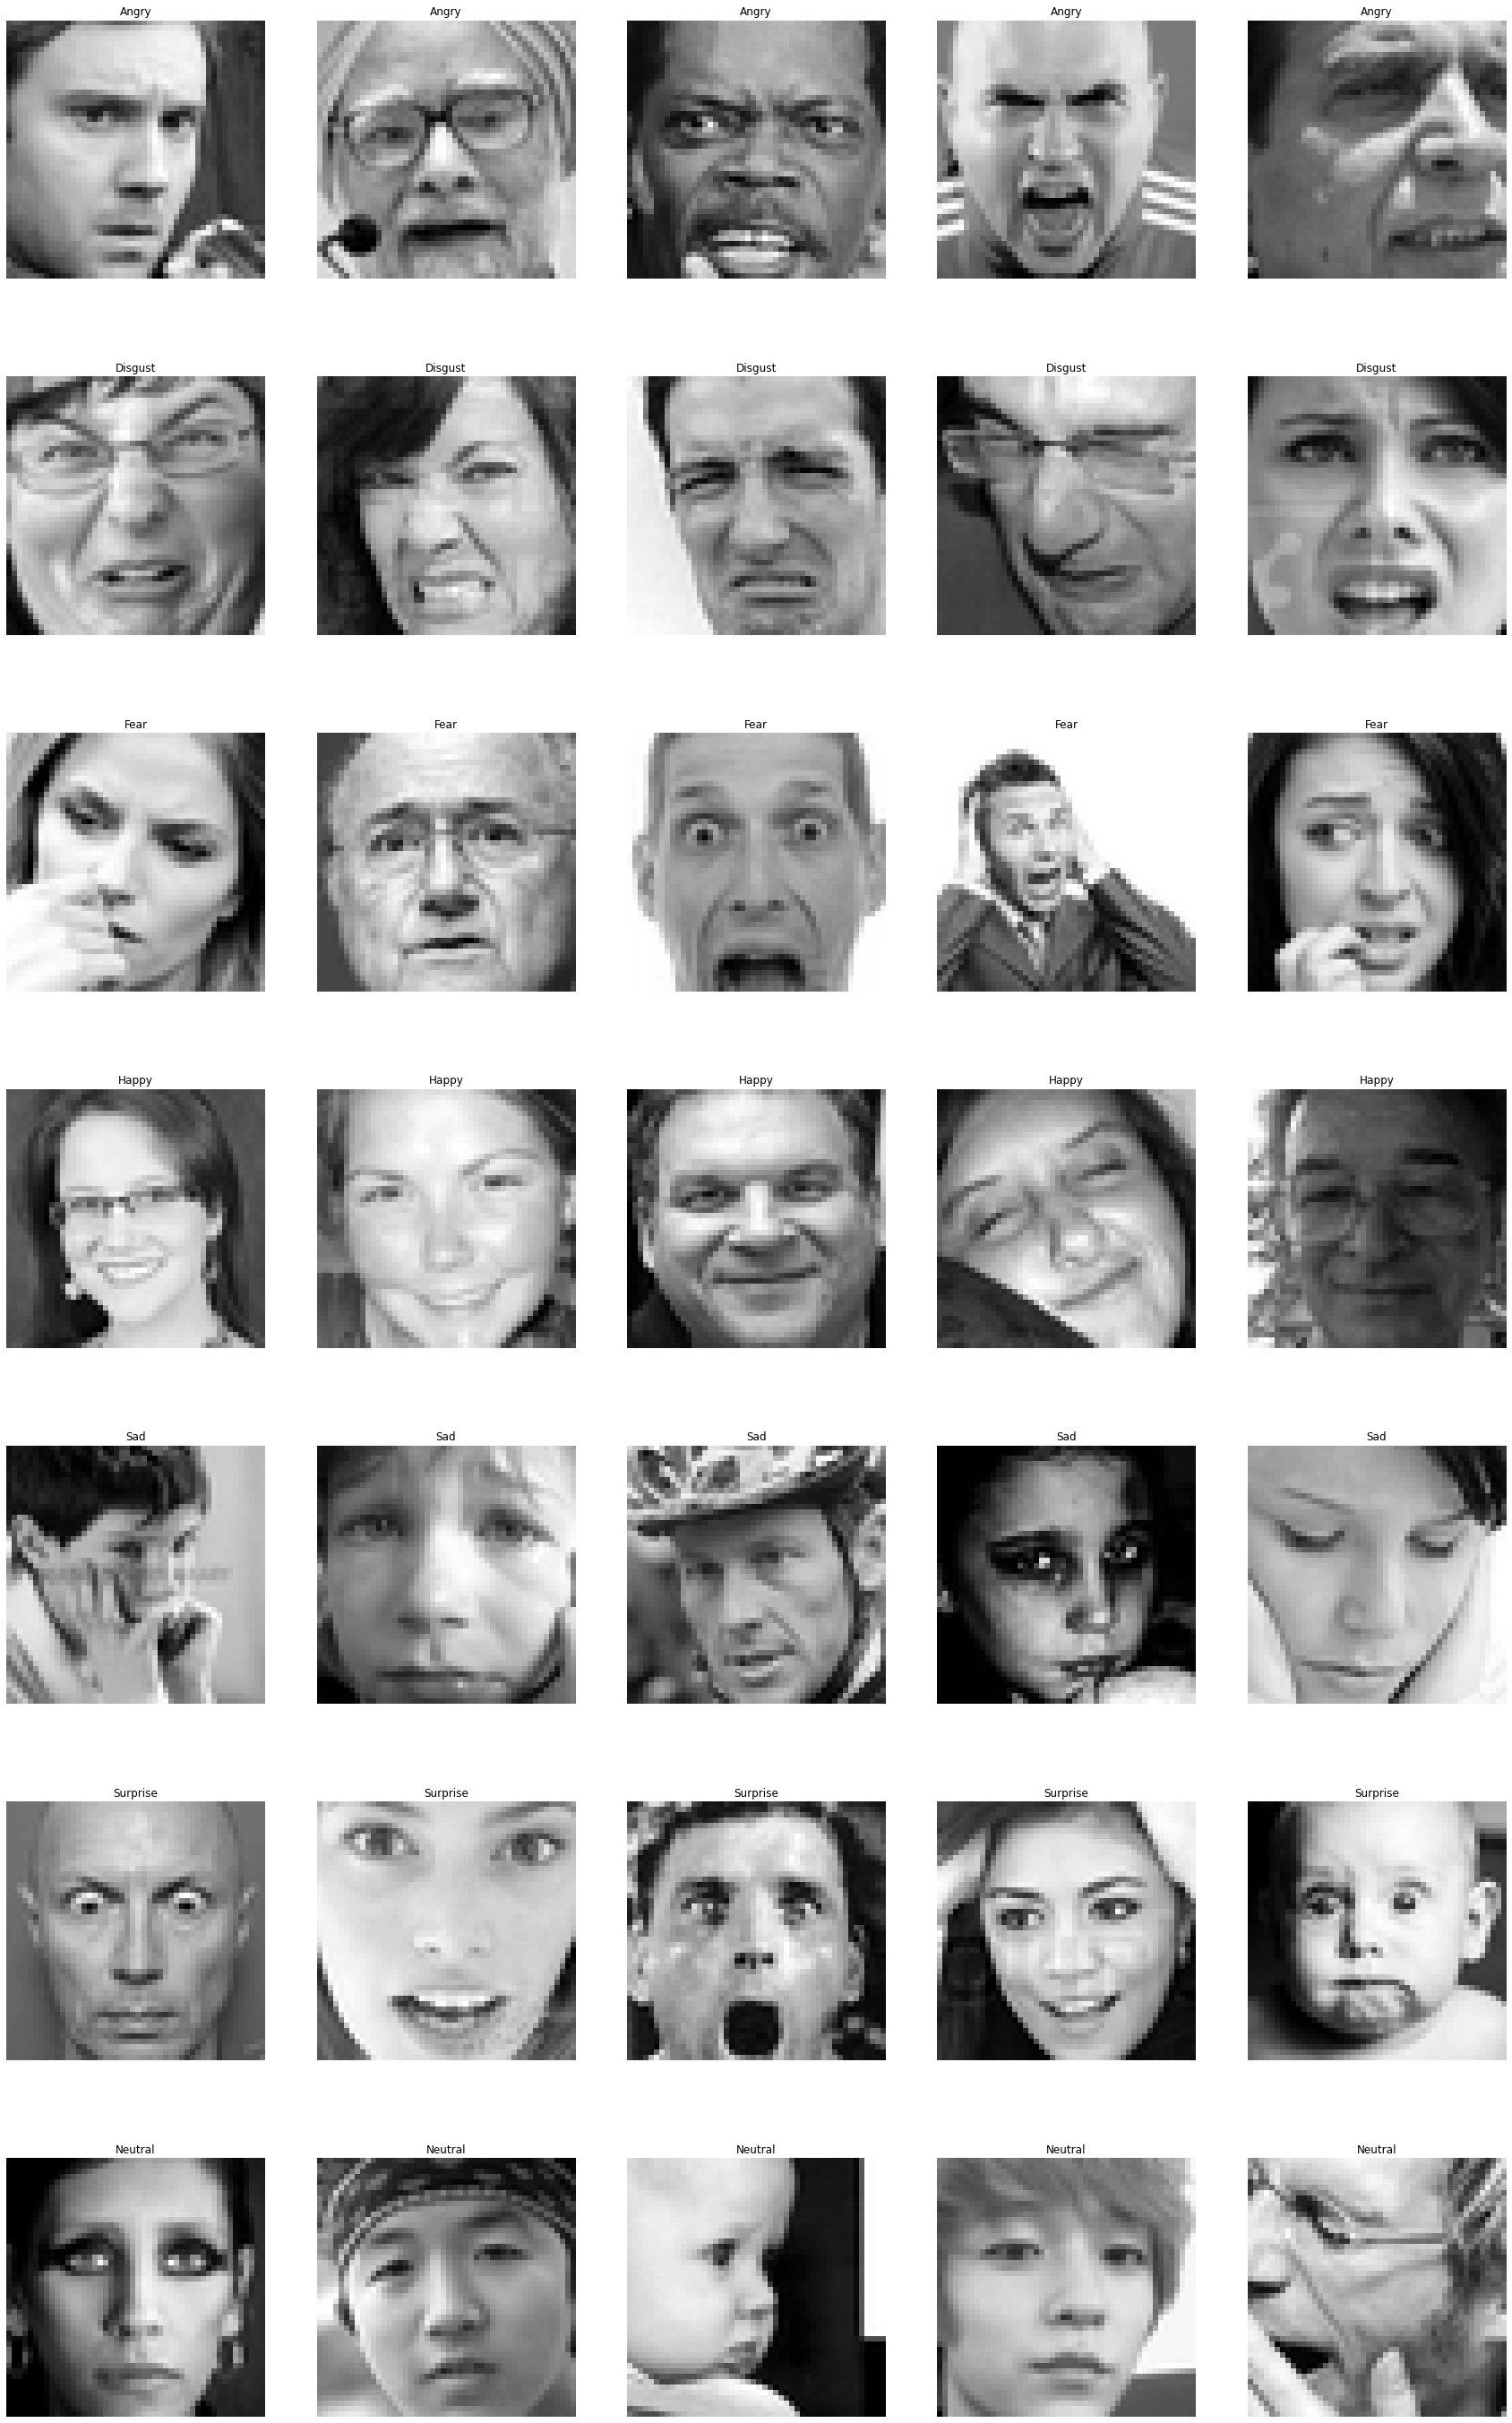

In [18]:
#10
img_ind_list = []
for i in range(7):
    img_ind_list.extend(train_df[train_df['emotion']==i][:5].index.tolist())
    
fig = plt.figure(figsize=(30,50))
for i,ind in enumerate(img_ind_list):
  ax = fig.add_subplot(7, 5, i + 1)
  ax.imshow(X_train[ind],cmap="gray")
  ax.set_title(emotions[y_train[ind]])
  ax.axis("off")
plt.show()

- これらの写真を見る限りは各感情の表情に特徴があり分類しやすいように思える。

# 5, 機械学習 <a id="5"></a>

### 5.1 データをトレインデータ、検証データ、テストデータに分ける

In [19]:
X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255
X_test = X_test.astype('float32')/255

In [20]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test_original = y_test.copy()
y_test = to_categorical(y_test)

### 5.2 モデル構築
- CNNを使ってモデルを構築する

In [21]:
#13
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2))) #プーリング層を使い特徴をより強調させる
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [22]:
#14
#model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

/Users/takeshiotani/opt/anaconda3/envs/kaggle_36/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
#15
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

### 5.3 モデルを学習させる

In [24]:
#16
h1 = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    class_weight = class_weight,
                    epochs=15,
                    batch_size=64)

Epoch 1/15
449/449 [==============================] - 18s 40ms/step - loss: 0.2632 - accuracy: 0.3300 - val_loss: 1.5528 - val_accuracy: 0.3937
Epoch 2/15
449/449 [==============================] - 19s 41ms/step - loss: 0.2264 - accuracy: 0.4371 - val_loss: 1.4452 - val_accuracy: 0.4642
Epoch 3/15
449/449 [==============================] - 20s 44ms/step - loss: 0.2069 - accuracy: 0.4876 - val_loss: 1.3578 - val_accuracy: 0.4968
Epoch 4/15
449/449 [==============================] - 20s 44ms/step - loss: 0.1931 - accuracy: 0.5234 - val_loss: 1.3272 - val_accuracy: 0.5043
Epoch 5/15
449/449 [==============================] - 20s 45ms/step - loss: 0.1829 - accuracy: 0.5516 - val_loss: 1.3235 - val_accuracy: 0.5107
Epoch 6/15
449/449 [==============================] - 22s 49ms/step - loss: 0.1737 - accuracy: 0.5729 - val_loss: 1.2496 - val_accuracy: 0.5391
Epoch 7/15
449/449 [==============================] - 23s 52ms/step - loss: 0.1651 - accuracy: 0.5966 - val_loss: 1.2796 - val_accuracy:

### 5.4 モデルの精度をepoch数を交えてグラフで確認する

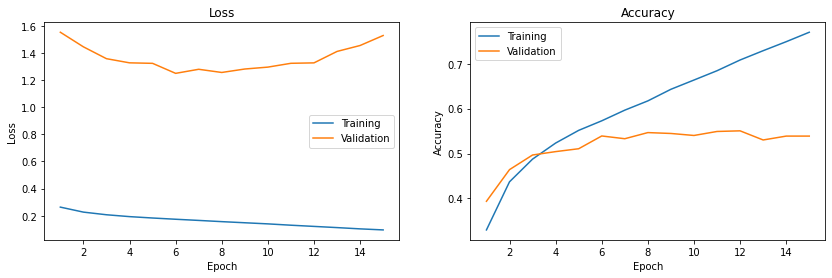

In [25]:
#17
history = h1.history

epoch_range = range(1, len(history['loss'])+1)

fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(epoch_range, history['loss'], label='Training')
ax.plot(epoch_range, history['val_loss'], label='Validation')
ax.set_xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(epoch_range, history['accuracy'], label='Training')
ax.plot(epoch_range, history['val_accuracy'], label='Validation')
ax.set_xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
ax.legend()
plt.show()

- モデルが過学習をしている

### 5.5 テストデータを使いモデルの精度を確認

In [26]:
#18
test_loss, test_acc = model.evaluate(X_test, y_test)
# 0.5188

113/113 [==============================] - 1s 12ms/step - loss: 1.5911 - accuracy: 0.5288


- テストデータでの精度: 0.5143

### 5.6 テストデータの各感情ごとの正解率、予測している総量、予測して正解している総量、正解の数量を確認する

In [27]:
pred_test = model.predict(X_test)

In [28]:
df_compare = pd.DataFrame()
df_compare['real'] = y_test.argmax(axis=1)
df_compare['pred'] = pred_test.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

/Users/takeshiotani/opt/anaconda3/envs/kaggle_36/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


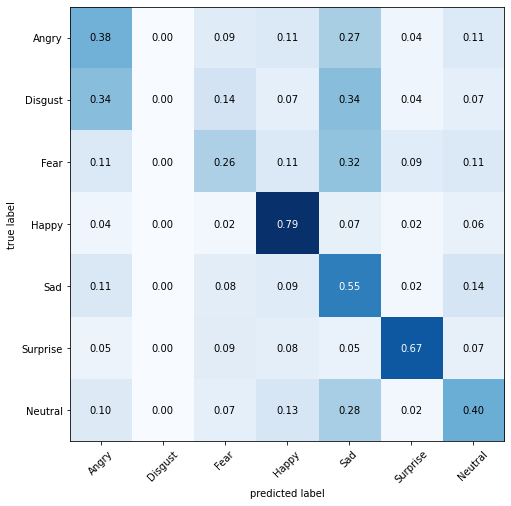

In [29]:
conf_mat = confusion_matrix(y_test.argmax(axis=1), pred_test.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions,
                                figsize=(8, 8))
fig.show()

- Happy, Sadに多く予測するモデルになっている、
- Sadに多く予測しているにもかかわらず半分ぐらいしか当たってない
- Disgustは全く予想されていない

### 5.7 テストデータを使いモデルの予測がどれぐらい自信があるか(各感情の予測が何パーセントか)確認

In [30]:
#20
y_test_reset_index = y_test_original.reset_index()
y_test_reset_index = y_test_reset_index.drop('index', axis=1)
emotions_ind_list = []
for n in range(7):
    emotions_ind_list.append(y_test_reset_index[y_test_reset_index.values == n].index[0])

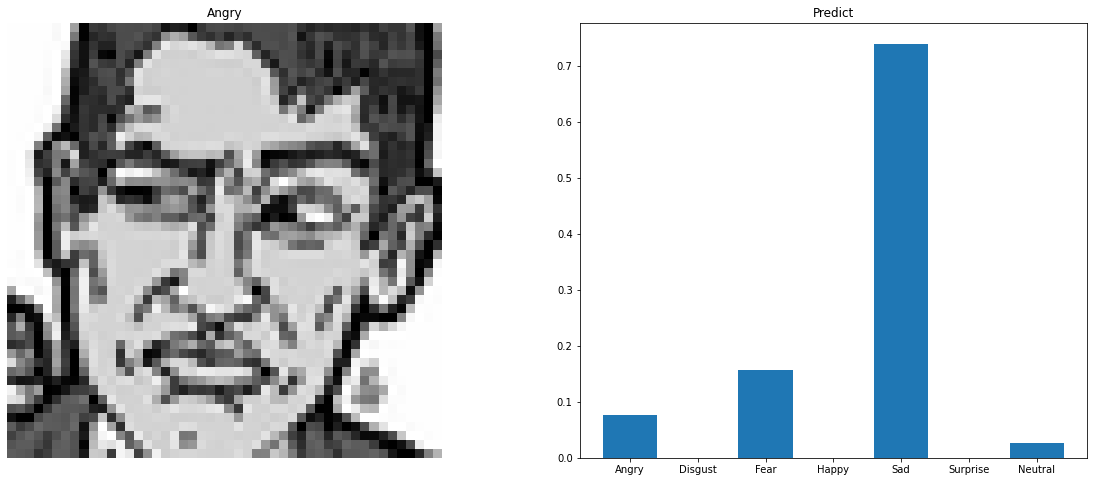

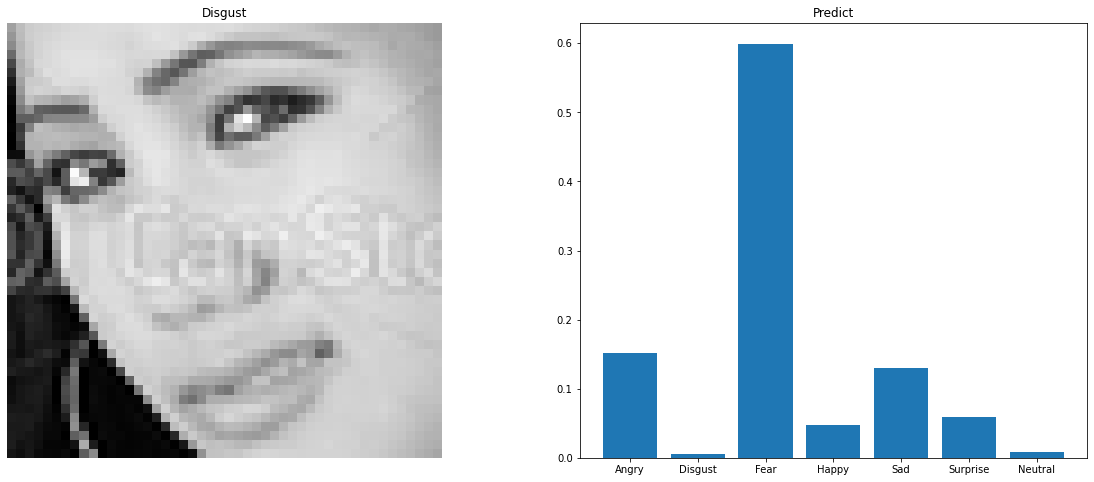

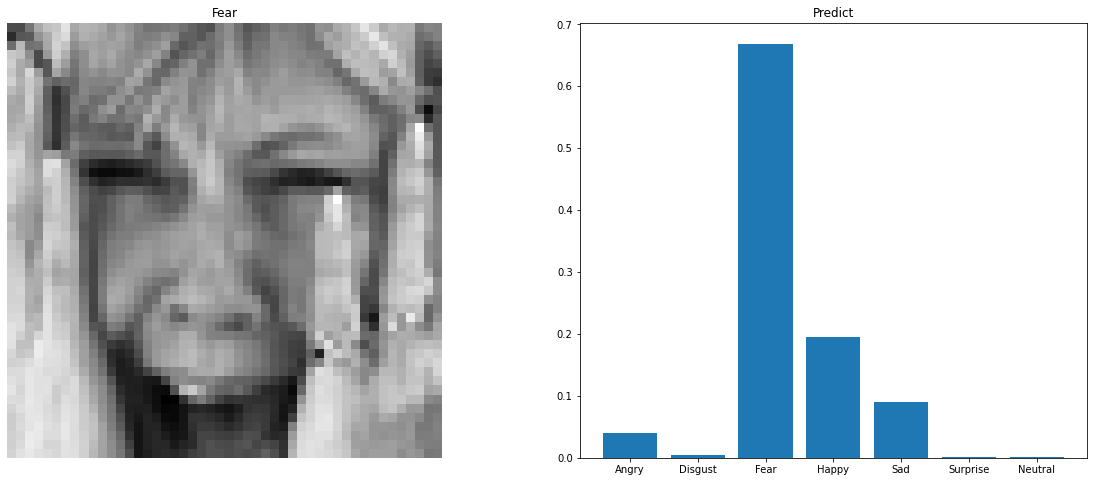

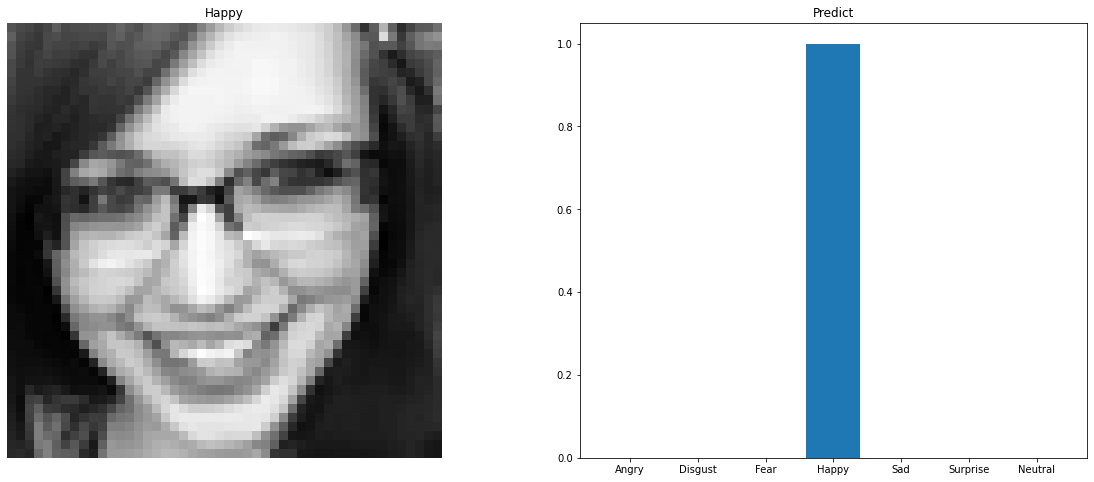

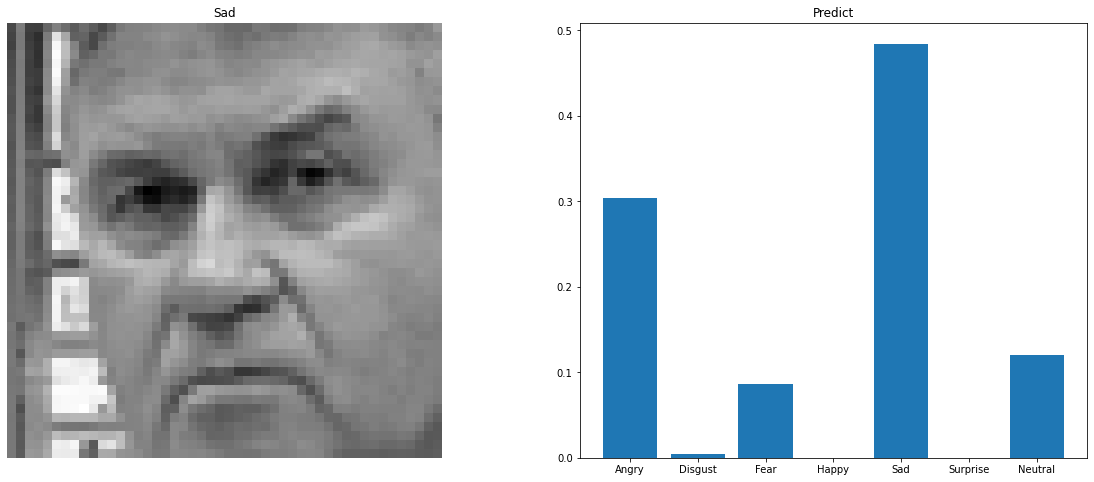

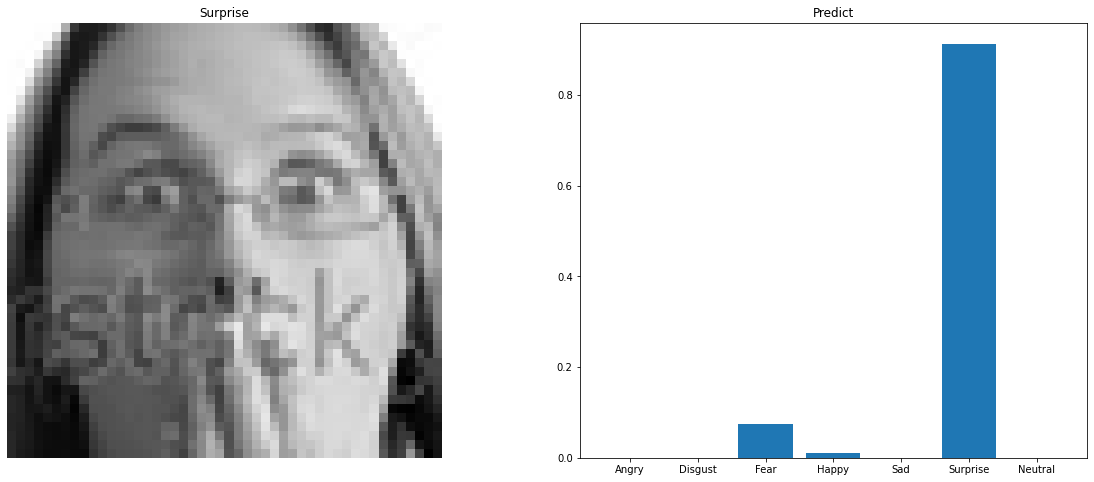

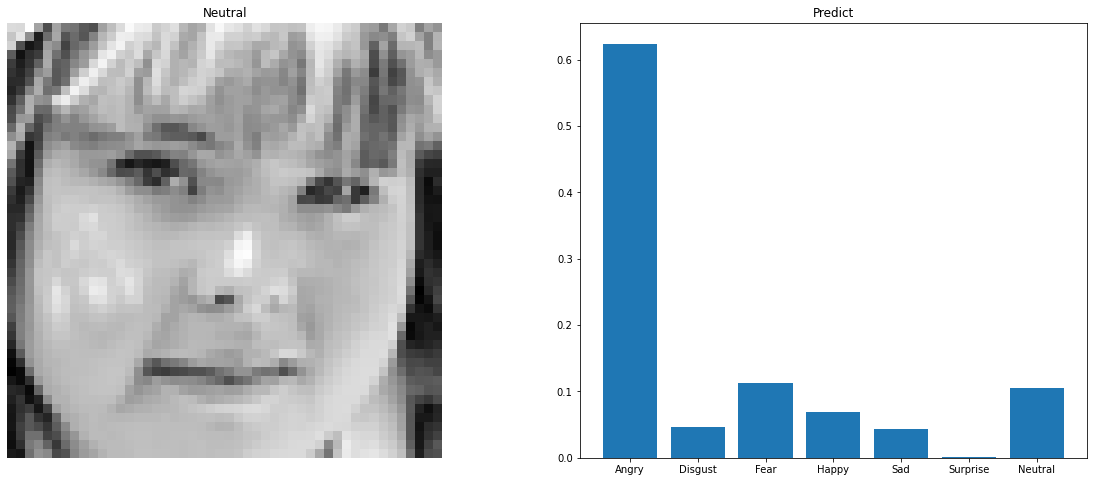

In [31]:
#21
for i, rand_ind in enumerate(emotions_ind_list):
    print
    fig = plt.figure(figsize=(20,8))
    temp = model.predict(X_test[rand_ind].reshape((1,48,48,1)))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(X_test[rand_ind],cmap="gray")
    ax.set_title(emotions[y_test_reset_index['emotion'][rand_ind]])
    ax.axis("off")
    ax_2 = fig.add_subplot(1, 2, 2)
    ax_2.bar(emotions, temp.tolist()[0], align="center")
    ax_2.set_title('Predict')
    plt.show()

- Happyは予測しやすいモデルになっていることが分かる
- 'Angry','Disgust','Fear','Sad'の区別があまりできていない。

# 6, 結果、まとめ <a id="6"></a>